# Riemannian Robust M-estimator

Lead author: Jihyun Ryu

This notebook shows how to compute location parameter from the data based on the concept of M-estimators. 
By taking advantage of the robustness property of several M-estimators in the Euclidean space, we will see that location parameter from the samples on a certain Riemannian manifold is properly computed in the case when data contaminated with a small amount of outliers on the same Riemannian manifold.

In [ ]:
#import os
#os.environ["GEOMSTATS_BACKEND"] = "autograd"

import geomstats.backend as gs

gs.has_autodiff()

True

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.riemannian_robust_m_estimator import (
    RiemannianRobustMestimator,
    riemannian_variance,
)

## ◎ On the sphere(dim = 2)

## Generate data on the sphere with 10% outlier

In [ ]:
def get_normalized_vector(x):
    """Get unit vector by normalizing with the norm."""
    return x / gs.linalg.norm(x)

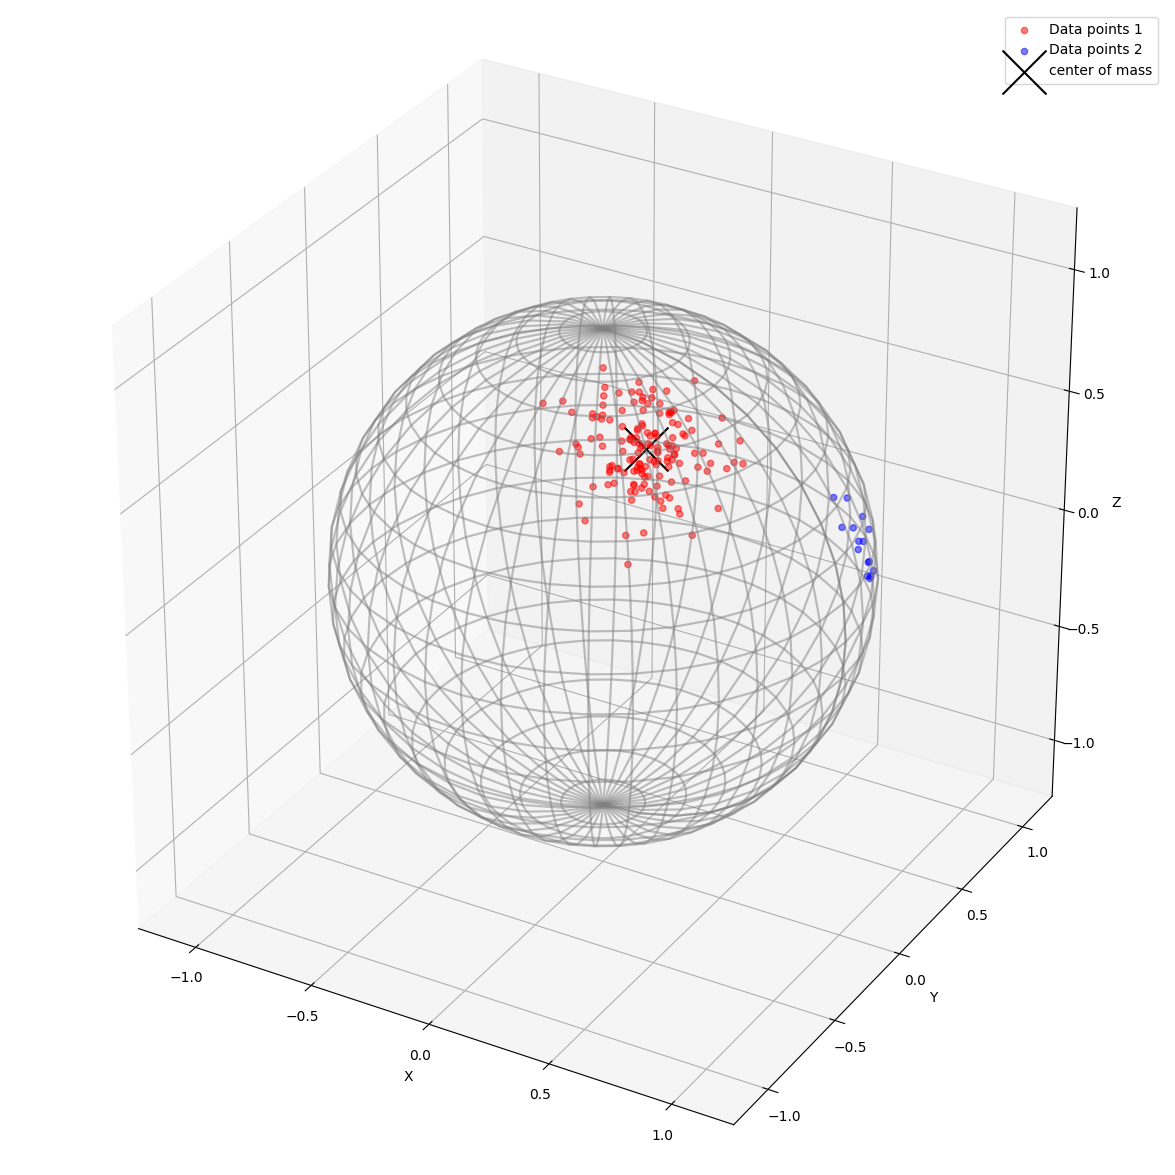

In [5]:
sphere = Hypersphere(dim=2)
n_samples = 150
outlier_ratio = 0.1
n_outliers = int(n_samples*outlier_ratio)

mu = get_normalized_vector(gs.array([0.3, -0.3, 0.6]))
cluster_1 = sphere.random_von_mises_fisher(kappa=50, n_samples=n_samples, mu=mu)

mu2 = get_normalized_vector(gs.array([0.7, 0.8, 0]))
cluster_2 = sphere.random_von_mises_fisher(kappa=100, n_samples=n_outliers, mu=mu2)

samples = gs.vstack((cluster_1,cluster_2))

fig = plt.figure(figsize=(15, 15))
ax = visualization.plot(
    cluster_1, space="S2", color="red", alpha=0.5, label="Data points 1 "
)
ax = visualization.plot(
    cluster_2, space="S2", ax=ax, color="blue", alpha=0.5, label="Data points 2"
)
ax = visualization.plot(
    mu, space="S2", ax=ax, color="black", alpha=1, s=1000, marker='x', label="center of mass"
)
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend();

In [6]:
print('center of mass:',mu)

center of mass: [ 0.40824829 -0.40824829  0.81649658]


## Select a robust M-estimator 
* huber_loss
* pseudo_huber_loss
* fair_loss
* cauchy_loss
* biweight_loss
* welsch_loss
* hampel_loss
* correntropy_loss
* logistic_loss
* lorentzian_loss

  
[DPSP2021] de Menezes, D.Q.F., Prata, D.M., Secchi, A.R., Pinto, J.C. “A review on robust M-estimators for regression analysis”, Computers & Chemical Engineering 147, 107254 (2021). https://doi.org/10.1016/j.compchemeng.2021.107254


#### The ρ functions of some representative robust m-estimators above are predefined and provided in the code. You can compute location parameter based on the samples on the manifold by choosing the proper ρ function style.

## Compute location parameter of M-estimator
### 1. Baseline(Fréchet mean)

In [7]:
mean = FrechetMean(sphere)
mean.fit(samples)
mean_estimate = mean.estimate_
print(mean_estimate)

[ 0.50425436 -0.29076482  0.81313182]


### 2. Huber Loss
[LJ2024] Lee, Jongmin, Jung, Sungkyu. “Huber means on Riemannian manifolds”, arXiv preprint arXiv:2407.15764, 2024. https://doi.org/10.48550/arXiv.2407.15764

In [8]:
# Autograd + huber
huber_auto = RiemannianRobustMestimator(sphere, 0.01, m_estimator='huber', method='autograd',init_point_method='mean-projection')
huber_auto.set(max_iter=1024,init_step_size=0.5, perturbation_epsilon=1e-7, epsilon=1e-10)
huber_auto.fit(samples)
print(huber_auto.estimate_.x)

[ 0.42397358 -0.38901514  0.8178714 ]


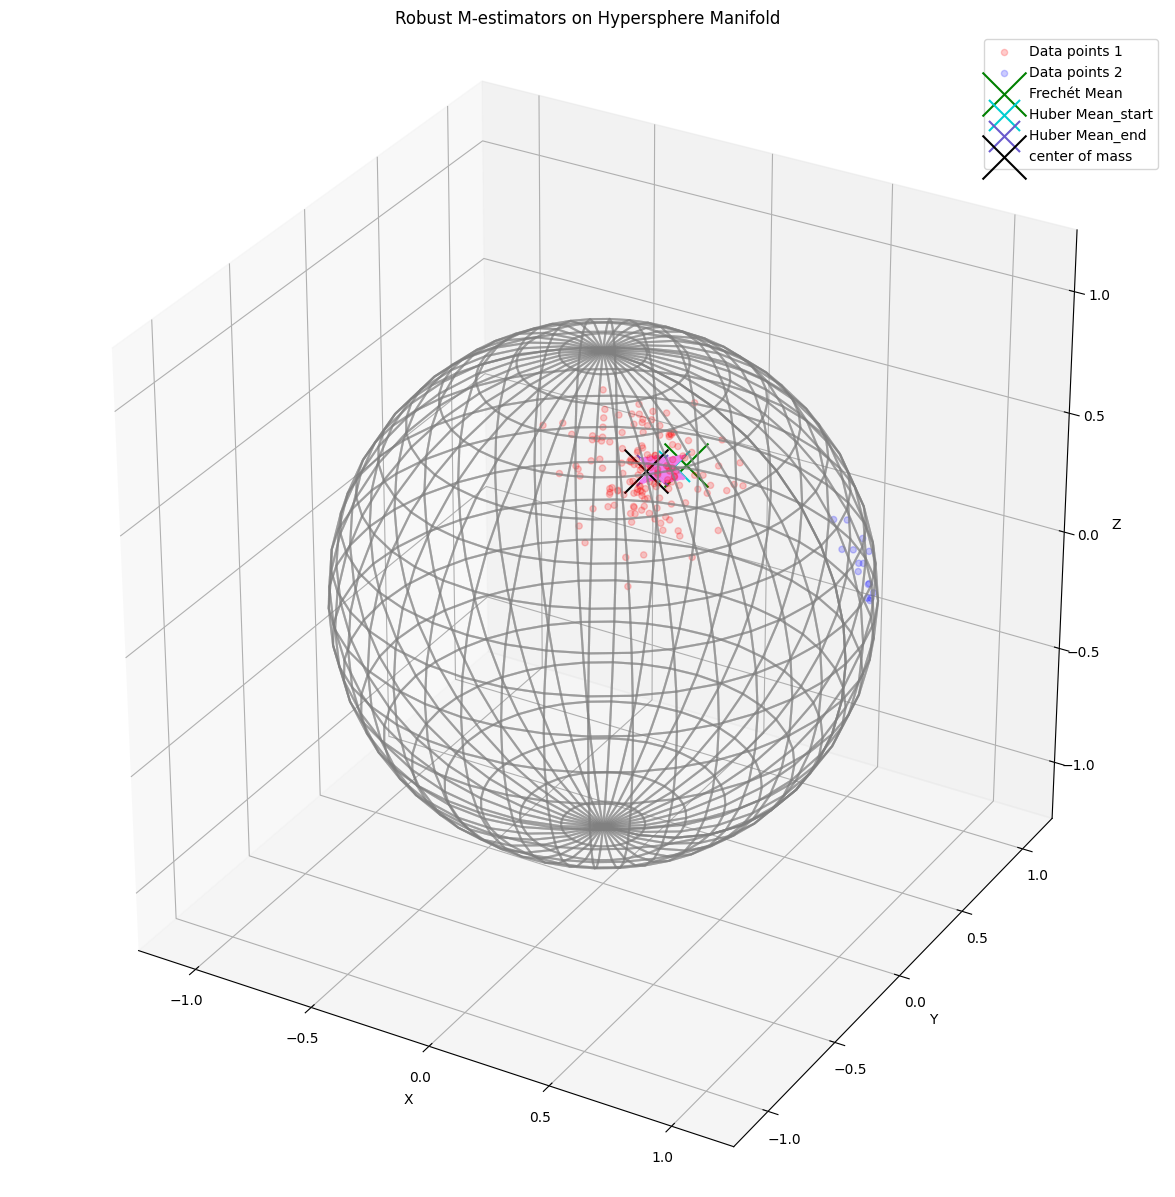

In [ ]:
fig = plt.figure(figsize=(15, 15))
colors = ["red", "blue"]

ax = visualization.plot(
    cluster_1, space="S2", color="red", alpha=0.2, label="Data points 1 "
)
ax = visualization.plot(
    cluster_2, space="S2", ax=ax, color="blue", alpha=0.2, label="Data points 2"
)

ax = visualization.plot(
    mean_estimate, space="S2", ax=ax, color="green", alpha=1, s=1000, marker='x', label="Fréchet Mean"
)
for i,c in enumerate(huber_auto.estimate_.bases):
    if i==0:
        ax = visualization.plot(c, ax=ax, space="S2", marker="x", s=500, color='darkturquoise', label='Huber Mean_start')
    elif i==len(huber_auto.estimate_.bases)-1:
        ax = visualization.plot(c, ax=ax, space="S2", marker="x", s=500, color='slateblue', label='Huber Mean_end')
    else:
        ax.scatter(*c, marker="x", s=300, color='violet',alpha=0.7)
ax = visualization.plot(
    mu, space="S2", ax=ax, color="black", alpha=1, s=1000, marker='x', label="center of mass"
)
ax.set_title("Robust M-estimators on Hypersphere Manifold")
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend();

### 3. fair loss

In [10]:
# Autograd + fair
fair_auto = RiemannianRobustMestimator(sphere, 2, m_estimator='fair', method='adaptive', init_point_method='mean-projection')
fair_auto.set(max_iter=512)
fair_auto.fit(samples)
print(fair_auto.estimate_.x)

[ 0.47331772 -0.3296001   0.8169052 ]


### 4. Hampel loss

In [11]:
# Autograd + Hampel
Hampel_auto = RiemannianRobustMestimator(sphere, 1, m_estimator='Hampel', method='autograd', init_point_method='mean-projection')
Hampel_auto.set(max_iter=512)
Hampel_auto.fit(samples)
print(Hampel_auto.estimate_.x)

[ 0.4749098  -0.32771015  0.81674154]


### 5. Tukey's biweight loss

In [12]:
# Autograd + biweight
biweight_auto = RiemannianRobustMestimator(sphere, 2.7, m_estimator='biweight', method='autograd', init_point_method='mean-projection')
biweight_auto.set(max_iter=512)
biweight_auto.fit(samples)
print(biweight_auto.estimate_.x)

[ 0.45562377 -0.34933927  0.81876068]


### 6. correntropy loss

In [13]:
# Autograd + correntropy
correntropy_auto = RiemannianRobustMestimator(sphere, 1.12, m_estimator='correntropy', method='autograd', init_point_method='mean-projection')
correntropy_auto.set(max_iter=1024)
correntropy_auto.fit(samples)
print(correntropy_auto.estimate_.x)

[ 0.44877596 -0.35673118  0.81935524]


## Plotting M-estimators 
#### Considering that all M-estimators derived are closer to the predefined center of mass than to the Fréchet mean, we clearly see that the outlier impact is diminished when utilizing Robust M-estimator functions. 
#### In this case, the distance from Huber mean to the center of mass is the lowest. But this is all because of cutoff setting before fitting. 
#### Thus, you should be careful to set cutoffs(critical value) of robust M-estimators. As the cutoff value increases, the impact of outlier increases.

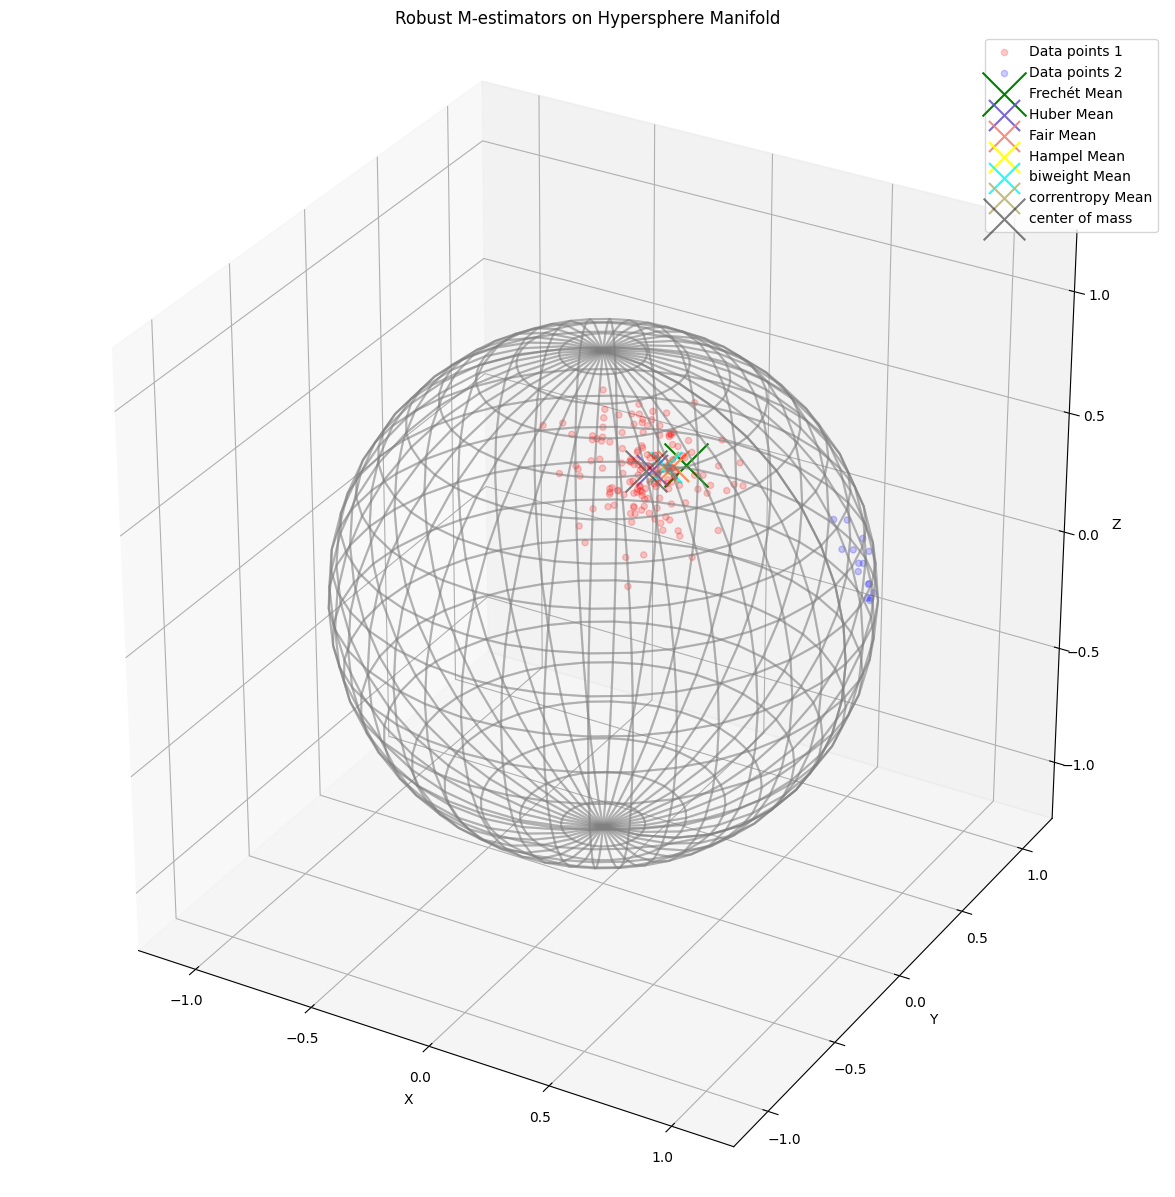

In [ ]:
fig = plt.figure(figsize=(15, 15))
colors = ["red", "blue"]

ax = visualization.plot(
    cluster_1, space="S2", color="red", alpha=0.2, label="Data points 1 "
)
ax = visualization.plot(
    cluster_2, space="S2", ax=ax, color="blue", alpha=0.2, label="Data points 2"
)

ax = visualization.plot(mean_estimate, ax=ax, space="S2", marker="x", s=1000, color='green', label='Fréchet Mean')
ax.scatter(*huber_auto.estimate_.x,  marker="x", alpha=0.9, s=500, color='slateblue', label='Huber Mean')
ax.scatter(*fair_auto.estimate_.x, marker="x", alpha=0.9, s=500, color='#FA8072', label='Fair Mean')
ax.scatter(*Hampel_auto.estimate_.x,  marker="x", alpha=0.9, s=500, color='yellow', label='Hampel Mean')
ax.scatter(*biweight_auto.estimate_.x, marker="x", alpha=0.9, s=500, color='cyan', label='biweight Mean')
ax.scatter(*correntropy_auto.estimate_.x, marker="x", alpha=0.9, s=500, color='#BDB76B', label='correntropy Mean')

ax = visualization.plot(
    mu, space="S2", ax=ax, color="black", alpha=0.5, s=900, marker='x', label="center of mass"
)
ax.set_title("Robust M-estimators on Hypersphere Manifold")
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend();

### In "autograd/pytorch" backend setting, you can give customized ρ function of M-estimator by which you can compute location parameter. 
### Because we now deal with the data on the Riemannian manifold, the customized ρ function must have the 3 inputs, "space(manifold), points(samples), base(base point needed for tangent space)".
### In order for a ρ function have robustness property, this type of customized ρ function should have critical value, which plays a role of threshold that diminishs the effect of outliers, needed to be set as input "critical_value".

## Custom Loss Template(Required):

In [ ]:
def custom_loss(space, points, base, critical_value=None, weights=None):
    """Customize Loss function.

    Parameter
    ---------
    space : manifold pre-defined
    points : data points to compute loss
    base : base point to get tangent space
    critical_value : optional, hyperparameter to control outlier impact 
    weights : optional, array-like, weight of each point
    """
    loss = 0
    # loss = define_loss_function(space, points, base, critical_value)
    # optional
    # gradient = gradient_of_loss(space, points, base) 
    return loss #(scalar) OR loss, gradient

- **Required arguments**: `space`, `points`, `base`
- **Optional**: `critical_value`, `weights`
- If `weights` is used, must satisfy `len(weights) == len(points)`

### Example:

In [ ]:
def basic1_loss(space, points, base, weights=None):
    """Set custom Loss function example.
    
    This case, Loss used to compute Fréchet mean.
    """
    n = len(points)
    if weights is None:
        weights = gs.ones(n)
    distances = space.metric.squared_dist(points, base)
    return gs.sum(weights * distances) / gs.sum(weights)

space = Hypersphere(2)
points = space.random_point(20)
c_value = 1
robust_mean = RiemannianRobustMestimator(space, c_value, method='autograd')
robust_mean._set_loss(fun=basic1_loss)
robust_mean.fit(points)

## ◎ On the Hyperbolic Space : Poincaré Ball
#### We deal with Poincaré Disk(dimension 2 Poincaré ball) to see the behavior of robust M-estimator.

### Generate random points on Poincaré Disk

In [17]:
pb = PoincareBall(2)
points = pb.random_point(n_samples = 100, bound = 0.5)
points = points + gs.array([[-0.3,-0.5]]*100)

points_outliers = pb.random_point(n_samples = 10, bound = 0.1)
points_outliers = points_outliers + gs.array([[-0.45,0.7]]*10)

samples = gs.vstack((points,points_outliers))

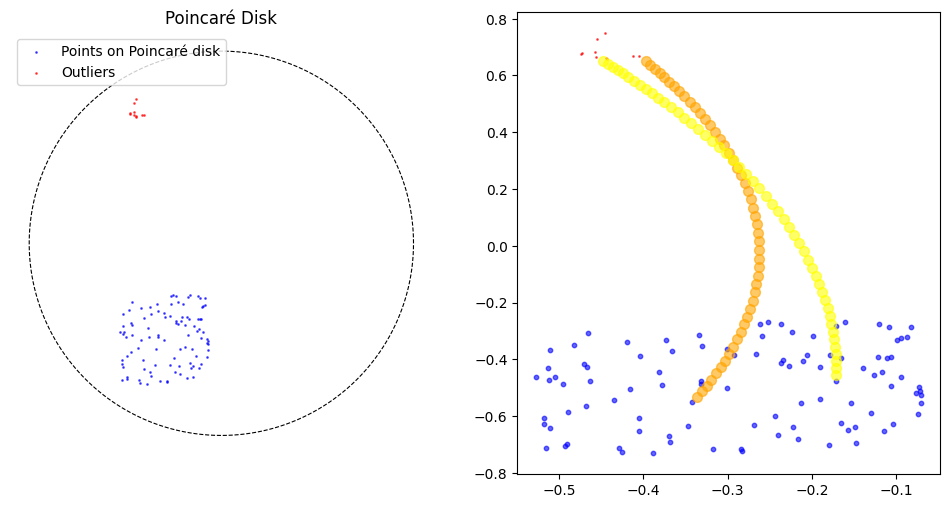

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
theta = gs.linspace(0,2*gs.pi,200)
ax[0].plot(gs.cos(theta), gs.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points[:,0], points[:,1], c='blue', alpha=0.6, s=1, label='Points on Poincaré disk')
ax[0].scatter(points_outliers[:,0], points_outliers[:,1], c='red', alpha=0.6, s=1, label='Outliers')

ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk")
ax[1].scatter(points[:,0], points[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')
ax[1].scatter(points_outliers[:,0], points_outliers[:,1], c='red', alpha=0.6, s=1, label='Outliers')

geodesics = pb.metric.geodesic(points[5],points_outliers[5])
ax[1].scatter(geodesics(gs.linspace(0.02,0.97,50))[:,0],geodesics(gs.linspace(0.02,0.97,50))[:,1],
              c='orange', s=50, alpha=0.6, label='geodesics_5_5')
geodesics = pb.metric.geodesic(points[51],points_outliers[0])
ax[1].scatter(geodesics(gs.linspace(0.02,0.97,50))[:,0],geodesics(gs.linspace(0.02,0.97,50))[:,1],
              c='yellow', s=50, alpha=0.6, label='geodesics_51_0')

## Example for Robust M-estimator on Hyperbolic space : Huber Mean
[LJ2024] Lee, Jongmin, Jung, Sungkyu. “Huber means on Riemannian manifolds”, arXiv preprint arXiv:2407.15764, 2024. https://doi.org/10.48550/arXiv.2407.15764

#### By setting critical values in 0.001 ~ 1000(details in code block) and computing each Huber mean and Fréchet mean 20 times respectively, we can figure out how far the Riemannian distance between each Huber mean and Fréchet mean compared to Riemannian sample variance, so that we test the difference between Fréchet mean and Huber means.

### Baseline : Fréchet Mean
#### To compare results and properties of M-estimators, we need to get baseline estimator, Fréchet mean.

In [ ]:
fm = FrechetMean(pb)
fm.set(max_iter=1024)
fm.fit(samples)
print('Fréchet Mean on Poincare Disk:',fm.estimate_.round(3))

Frechét Mean on Poincare Disk: [-0.271 -0.394]


### Simulation : 
#### To see the behavior of robust M-estimator with the outlier, we compute M-estimator(Huber mean) with varying cutoffs(critical_value) ranging from 0.001 to 100.

In [ ]:
critical_values = [0.001,0.01,0.1,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.25,2.5,2.75,3,5,10,100]
iterations = 20
starting_points = gs.random.choice(range(samples.shape[0]),iterations,replace=False)
results = []
for i in range(iterations):
    sp = starting_points[i] 
    fm = FrechetMean(pb)
    fm.set(max_iter=50000,init_point=samples[sp])
    tic = time.time()
    fm.fit(samples)
    results.append([i,'Frechet Mean',np.inf,fm.estimate_,np.nan,time.time()-tic,0])
    
    for c in critical_values:        
        huberM = RiemannianRobustMestimator(pb, c, m_estimator='huber', method='adaptive',init_point_method='first')
        huberM.set(max_iter=50000, init_step_size=0.5, init_point=samples[sp], epsilon=1e-10)
        tic = time.time()
        huberM.fit(samples)
        results.append([i,'Huber Mean',c,huberM.estimate_.x,len(huberM.estimate_.bases),time.time()-tic,sp])
        
res = pd.DataFrame(results,columns=['i','name','c','base','opt_iters','time','start_point'])        
res_summary = res.groupby(['name','c']).base.apply(
    lambda x:riemannian_variance(pb,np.array(x.tolist()),get_centroid=True)
).reset_index()
res_summary['sample_mean'] = [i[1] for i in res_summary['base']]
res_summary['sample_std'] = [gs.sqrt(i[0]) for i in res_summary['base']]

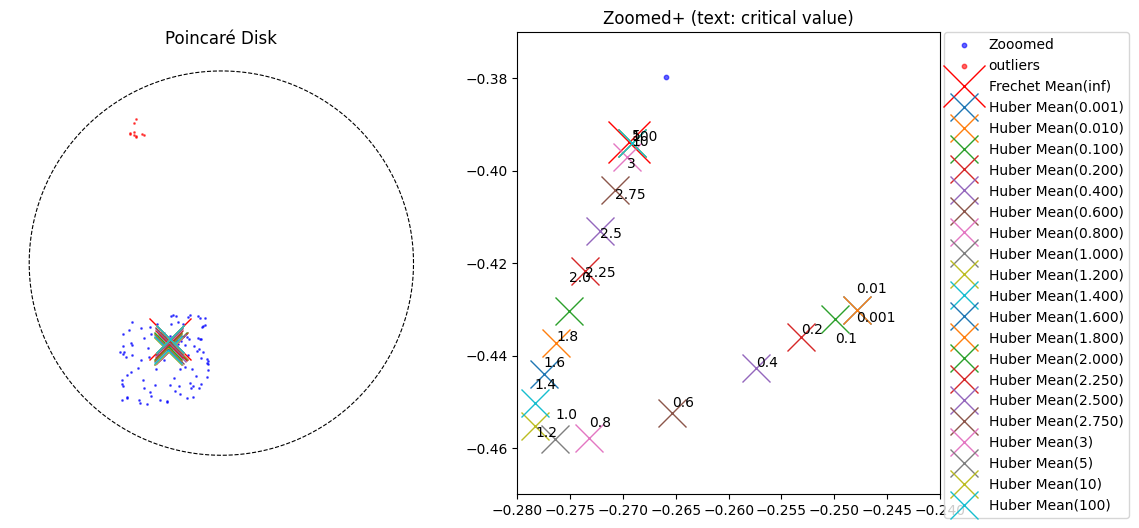

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
theta = np.linspace(0,2*np.pi,200)
ax[0].plot(np.cos(theta), np.sin(theta), 'k--', lw=0.8)
ax[0].scatter(points[:,0], points[:,1], c='blue', alpha=0.6, s=1, label='Samples on Poincare disk')
ax[0].scatter(points_outliers[:,0], points_outliers[:,1], c='red', alpha=0.6, s=1, label='outliers')
# ax[0].set_xlim([-1.1, 1.1])
# ax[0].set_ylim([-1.1, 1.1])
ax[0].set_aspect('equal')
ax[0].axis('off')
#ax[0].legend(loc='upper left')
ax[0].set_title("Poincaré Disk")

for i,r in res_summary.iterrows():
    if r['name']=='Frechet Mean':
        ax[0].plot(r['sample_mean'][0],r['sample_mean'][1],'x',c='red',markersize=30,
                   label='{}({:.3f})'.format(r['name'],r['c']))    
    else:
        ax[0].plot(r['sample_mean'][0],r['sample_mean'][1],'x',markersize=20,
                   label='{}({:.3f})'.format(r['name'],r['c']) if r['c']<3 else'{}({})'.format(r['name'],int(r['c'])))


ax[1].scatter(points[:,0], points[:,1], c='blue', alpha=0.6, s=10, label='Zooomed')
ax[1].scatter(points_outliers[:,0], points_outliers[:,1], c='red', alpha=0.6, s=10, label='outliers')
for i,r in res_summary.iterrows():
    if r['name']=='Frechet Mean':
        ax[1].plot(r['sample_mean'][0],r['sample_mean'][1],'x',c='red',markersize=30,
                   label='{}({:.3f})'.format(r['name'],r['c']))    
    else:
        ax[1].plot(r['sample_mean'][0],r['sample_mean'][1],'x',markersize=20,
                   label='{}({:.3f})'.format(r['name'],r['c']) if r['c']<3 else'{}({})'.format(r['name'],int(r['c'])))
        ax[1].text(r['sample_mean'][0],r['sample_mean'][1]+np.random.normal(0,0.0037,1),r['c'] if r['c']<3 else int(r['c']))

ax[1].set_xlim(-0.28,-0.24)
ax[1].set_ylim(-0.47,-0.37)
ax[1].set_title('Zoomed+ (text: critical value)')
ax[1].legend( loc='upper left',bbox_to_anchor=(1.01,1),borderaxespad=0.)

#### Seeing Riemannian distances of pairwise samples, we need to set appropriate cutoff value to differentiate robust M-estimators from Fréchet mean.
#### In this case, by setting cutoff(critical value) less than 2, we can reduce the impact of outliers.
#### In real-life case, However, we have no information about which point is an outlier. Thus, setting proper cutoff value becomes crucial part of robust data analysis.

Text(0.5, 1.0, 'Riemannian Pairwise Distances of All Samples')

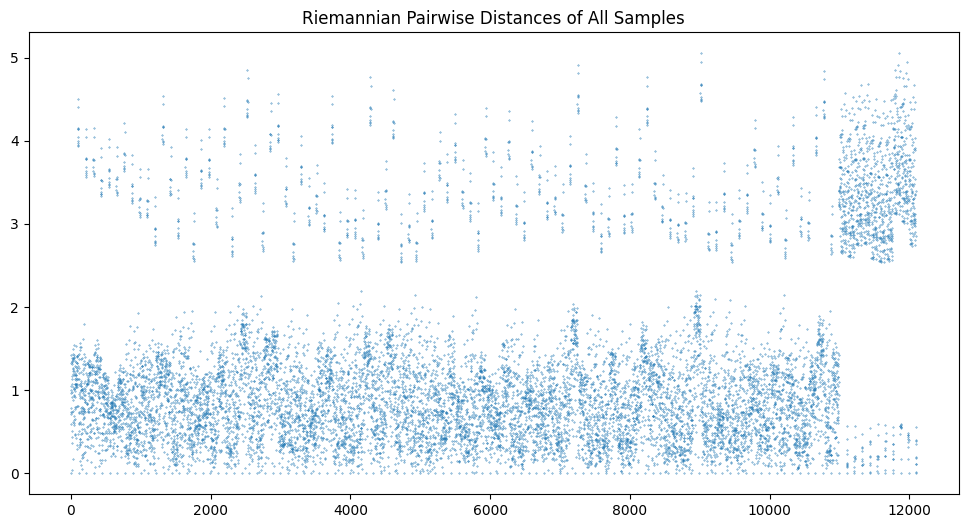

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(x=range(len(samples)**2), y=pb.metric.dist_pairwise(samples).reshape(-1),s=0.1,marker='o')
plt.title('Riemannian Pairwise Distances of All Samples')